# ML lecture 2

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals, unicode_literals

import pathlib
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## CNN
https://developers.google.com/machine-learning/practica/image-classification/exercise-1

https://colab.research.google.com/github/google/eng-edu/blob/master/ml/pc/exercises/image_classification_part1.ipynb?utm_source=practicum-IC&utm_campaign=colab-external&utm_medium=referral&hl=en&utm_content=imageexercise1-colab

https://github.com/watson-ij/knu-keras-tute-2019/blob/master/20190925-mltute-iwatson.org

## GANs

https://towardsdatascience.com/writing-your-first-generative-adversarial-network-with-keras-2d16fd8d4889

https://developers.google.com/machine-learning/gan

https://github.com/watson-ij/knu-keras-tute-2019/blob/master/20190925-mltute-iwatson.org

## BNN (Variational layer in tensorflow probabaility) 

https://medium.com/tensorflow/regression-with-probabilistic-layers-in-tensorflow-probability-e46ff5d37baf

http://krasserm.github.io/2019/03/14/bayesian-neural-networks/
(This is useful but you may find the code may not work.
You can use following modified code)

In [35]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import tensorflow as tf
from tensorflow.python import tf2
if not tf2.enabled():
  import tensorflow.compat.v2 as tf
  tf.enable_v2_behavior()
  assert tf2.enabled()

import tensorflow_probability as tfp

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from pathlib import Path


sns.reset_defaults()
#sns.set_style('whitegrid')
#sns.set_context('talk')
sns.set_context(context='talk',font_scale=0.7)

%matplotlib inline

tf.keras.backend.set_floatx('float64')              

tfd = tfp.distributions

In [36]:
negloglik = lambda y, rv_y: -rv_y.log_prob(y)

def f(x, sigma):
    epsilon = np.random.randn(*x.shape) * sigma
    return 10 * np.sin(2 * np.pi * (x)) + epsilon

#def f(x, sigma):
#    epsilon = np.random.randn(*x.shape) * sigma
#    return x + 0.3*np.sin(2*np.pi*(x+epsilon))+ 0.3*np.sin(4*np.pi*(x+epsilon)) +epsilon

train_size = 100
noise = 0.1

X = np.linspace(-0.5, 0.5, train_size).reshape(-1, 1)
y = f(X, sigma=noise)

batch_size = train_size

def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))
    return tf.keras.Sequential([
        tfp.layers.VariableLayer(2 * n, dtype=dtype),
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=t[..., :n],
                     scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
            reinterpreted_batch_ndims=1)),
  ])

#def prior_trainable(kernel_size, bias_size=0, dtype=None):
#  n = kernel_size + bias_size
#  c = np.log(np.expm1(1.))
#  return tf.keras.Sequential([
#      tfp.layers.VariableLayer(2 * n, dtype=dtype),
#      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
#          tfd.Normal(loc=t[..., :n], 
#                     scale=1e-5 + tf.nn.softplus(c + t[..., n:]) ),
#          reinterpreted_batch_ndims=1)),
#  ])

def prior_trainable(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))
    return tf.keras.Sequential([
        tfp.layers.VariableLayer(2 * n, dtype=dtype),
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=t[..., :n], scale=1.0 ),
            reinterpreted_batch_ndims=1)),
  ])
# Build model.
model = tf.keras.Sequential([
    tfp.layers.DenseVariational(20, posterior_mean_field, prior_trainable, 
                                kl_weight=1/X.shape[0],
                              activation='relu'),
    tfp.layers.DenseVariational(20, posterior_mean_field, prior_trainable, 
                                kl_weight=1/X.shape[0],
                              activation='relu'),
    tfp.layers.DenseVariational(1, posterior_mean_field, prior_trainable,
                               kl_weight=1/X.shape[0]),
    tfp.layers.DistributionLambda(
      lambda t: tfd.Independent(tfd.Normal(loc=t[..., :1], scale=1.0 ),
          reinterpreted_batch_ndims=1))  
])

# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)

model.fit(X, y,batch_size=4, epochs=550, verbose=False);

# Profit.
#[print(np.squeeze(w.numpy())) for w in model.weights];
yhat = model(X)
assert isinstance(yhat, tfd.Distribution)

In [37]:
# sampling output 

X_test = np.linspace(-1.0, 1.0, 1000).reshape(-1, 1)

y_pred_list=[]
yhats = [model(X_test) for _ in range(200)]

for i, yhat in enumerate(yhats):
    m = np.squeeze(yhat.mean())
    y_pred_list.append(m)

y_preds=np.array(y_pred_list)
y_mean = np.mean(y_preds, axis=0)
y_sigma = np.std(y_preds, axis=0)

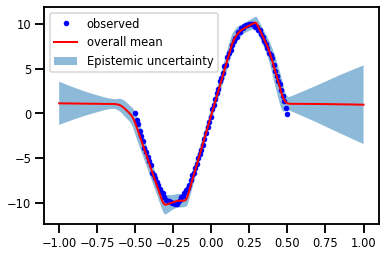

In [41]:
plt.plot(X, y, 'b.', label='observed');
plt.plot(X_test, y_mean , 'r', linewidth=2, label=r'overall mean ');
#plt.plot(X_test, y_mean + 2 * y_sigma, 'g', linewidth=2, label=r'mean + 2 stddev');
#plt.plot(X_test, y_mean - 2 * y_sigma, 'g', linewidth=2, label=r'mean - 2 stddev');
#for _ in range(3):
#    plt.plot(X_test,y_preds[_,:],'y')



plt.fill_between(X_test.ravel(), 
                 y_mean + 2 * y_sigma, 
                 y_mean - 2 * y_sigma, 
                 alpha=0.5, label='Epistemic uncertainty')
plt.legend()

## SVM

In [31]:
import numpy as np
# import cvxopt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix

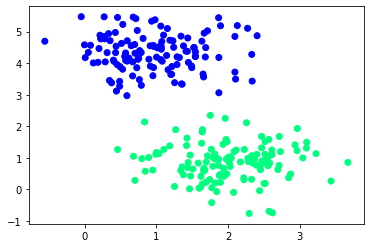

In [32]:
# Make dataset 
X, y = make_blobs(n_samples=250, centers=2,
                  random_state=0, cluster_std=0.60)
y[y == 0] = -1
tmp = np.ones(len(X))
y = tmp * y
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='winter')

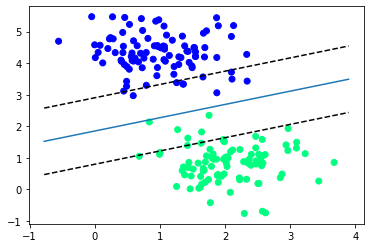

In [33]:
# split data 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Prepare SVM (linear kernel)
svc = LinearSVC()
svc.fit(X_train, y_train)

#plot 
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='winter');
ax = plt.gca()
xlim = ax.get_xlim()
w = svc.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(xlim[0], xlim[1])
yy = a * xx - svc.intercept_[0] / w[1]
plt.plot(xx, yy)
yy = a * xx - (svc.intercept_[0] - 1) / w[1]
plt.plot(xx, yy, 'k--')
yy = a * xx - (svc.intercept_[0] + 1) / w[1]
plt.plot(xx, yy, 'k--')

In [34]:
# test/predict 
y_pred = svc.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[29,  0],
       [ 0, 34]], dtype=int64)

## GPs

modified from sklearn example
https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_prior_posterior.html

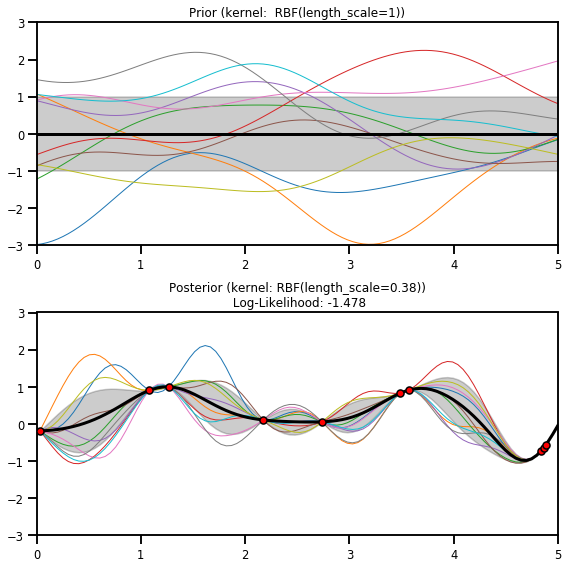

In [42]:
import numpy as np

from matplotlib import pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0))
gp = GaussianProcessRegressor(kernel=kernel)

# Plot prior
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
X_ = np.linspace(0, 5, 100)
y_mean, y_std = gp.predict(X_[:, np.newaxis], return_std=True)
plt.plot(X_, y_mean, 'k', lw=3, zorder=9)
plt.fill_between(X_, y_mean - y_std, y_mean + y_std,
                     alpha=0.2, color='k')
y_samples = gp.sample_y(X_[:, np.newaxis], 10)
plt.plot(X_, y_samples, lw=1)
plt.xlim(0, 5)
plt.ylim(-3, 3)
plt.title("Prior (kernel:  %s)" % kernel, fontsize=12)

# Generate data and fit GP
rng = np.random.RandomState(4)
X = rng.uniform(0, 5, 10)[:, np.newaxis]
y = np.sin((X[:, 0] - 2.5) ** 2)
gp.fit(X, y)

# Plot posterior
plt.subplot(2, 1, 2)
X_ = np.linspace(0, 5, 100)
y_mean, y_std = gp.predict(X_[:, np.newaxis], return_std=True)
plt.plot(X_, y_mean, 'k', lw=3, zorder=9)
plt.fill_between(X_, y_mean - y_std, y_mean + y_std,
                     alpha=0.2, color='k')

y_samples = gp.sample_y(X_[:, np.newaxis], 10)
plt.plot(X_, y_samples, lw=1)
plt.scatter(X[:, 0], y, c='r', s=50, zorder=10, edgecolors=(0, 0, 0))
plt.xlim(0, 5)
plt.ylim(-3, 3)
plt.title("Posterior (kernel: %s)\n Log-Likelihood: %.3f"
              % (gp.kernel_, gp.log_marginal_likelihood(gp.kernel_.theta)),
              fontsize=12)
plt.tight_layout()

plt.show()

## VAE

https://keras.io/examples/generative/vae/